In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3'

In [2]:
#from src.ModelTransfuser_cfg import ModelTransfuser as MTf
from src.ModelTransfuser_trainer import ModelTransfuser as MTf
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
from torch.utils.data import DataLoader
import pandas as pd

from scipy.stats import norm, gaussian_kde
from scipy import optimize

import os

%matplotlib inline
%load_ext line_profiler

In [3]:
def gen_data(int):
    theta1 = torch.randn(int) * 3
    x1 = 2 * torch.sin(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return torch.stack([theta1, x1, x2])

In [4]:
data = gen_data(10_000)
#data_loader = DataLoader(data.T, batch_size=64, shuffle=True)
val_data = gen_data(1000)
#val_data_loader = DataLoader(val_data.T, batch_size=64, shuffle=True)
nodes_max = data.shape[0]
node_ids = torch.arange(nodes_max)

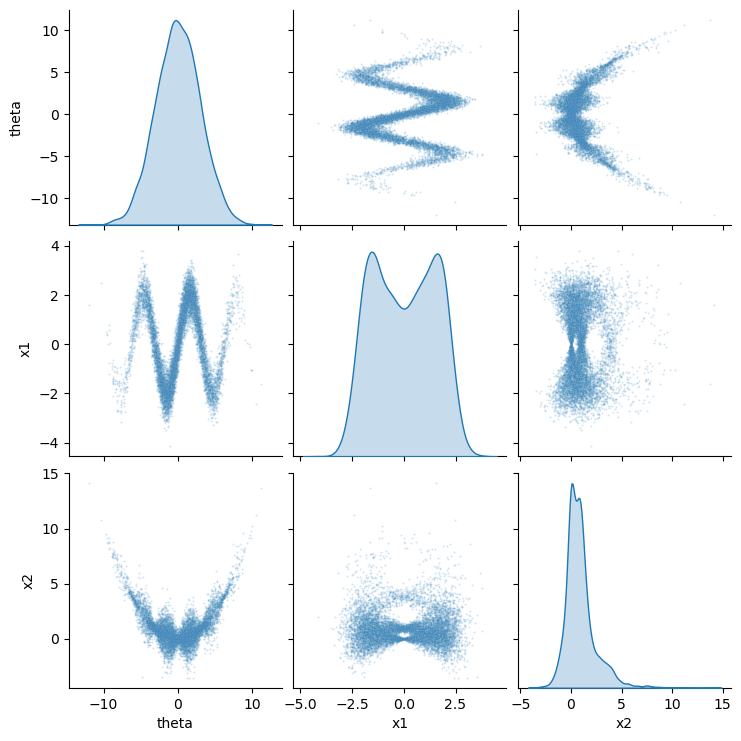

In [5]:
df = pd.DataFrame(data.T.numpy(), columns=['theta', 'x1', 'x2'])
sns.pairplot(df, diag_kind='kde', plot_kws=dict(alpha=0.2, s=2))
plt.show()

In [6]:
model = MTf(nodes_max, depth=4, num_heads=4, sigma=5, hidden_size=64)

In [7]:
model.train(data.T, val_data=val_data.T, verbose=False, device='cuda', batch_size=128) 

In [8]:
# epoch = np.arange(0, len(model.trainer.train_loss))

# plt.plot(epoch, np.array(model.trainer.train_loss), label='Train Loss')
# plt.plot(epoch, np.array(model.trainer.val_loss), label='Val Loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [9]:
condition_mask = torch.zeros(nodes_max)

In [10]:
#model.model.load_state_dict(torch.load("data/models/test/Model_checkpoint.pt"))

In [11]:
s = model.sample(data=torch.zeros(10,3), condition_mask=condition_mask, num_samples=1000, method="euler", device="cuda", timesteps=1000)

100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


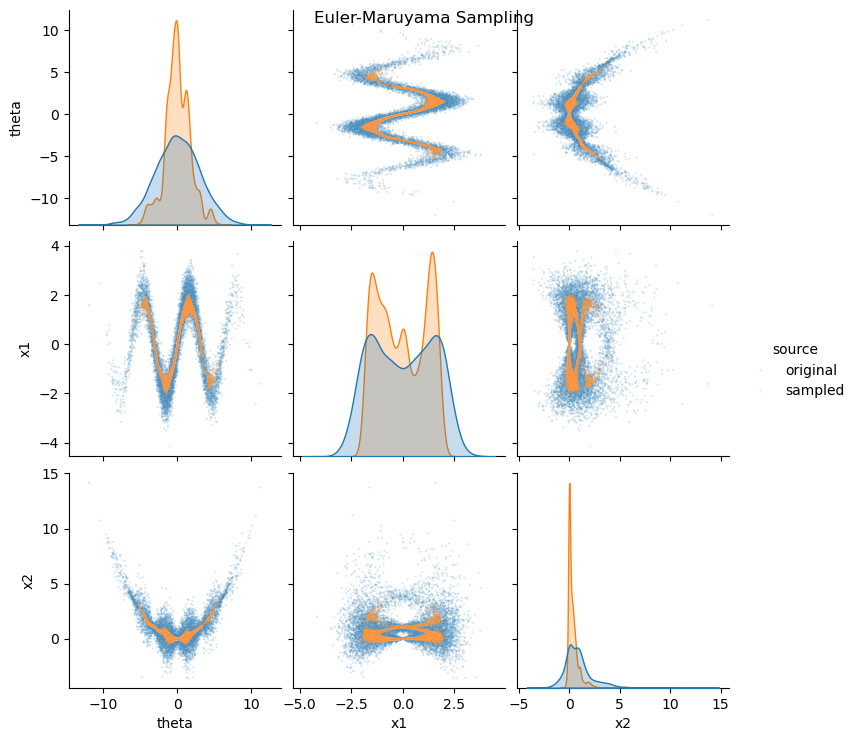

In [12]:
df_og = pd.DataFrame(data.T.numpy(), columns=['theta', 'x1', 'x2'])
df = pd.DataFrame(s.permute(2,1,0).flatten(1).T.cpu().numpy(), columns=['theta', 'x1', 'x2'])

df_og['source'] = 'original'
df['source'] = 'sampled'

df_combined = pd.concat([df_og, df], axis=0)

pp = sns.pairplot(df_combined, hue='source', diag_kind='kde', diag_kws=dict(common_norm=False), plot_kws=dict(alpha=0.2, s=2))
pp.fig.suptitle("Euler-Maruyama Sampling")
plt.show()

In [13]:
s = model.sample(data=torch.zeros(10,3), condition_mask=condition_mask, num_samples=1000, method="dpm", device="cuda", timesteps=20, order=2, final_corrector_steps=10, corrector_steps_interval=5, corrector_steps=5, snr=0.1)

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


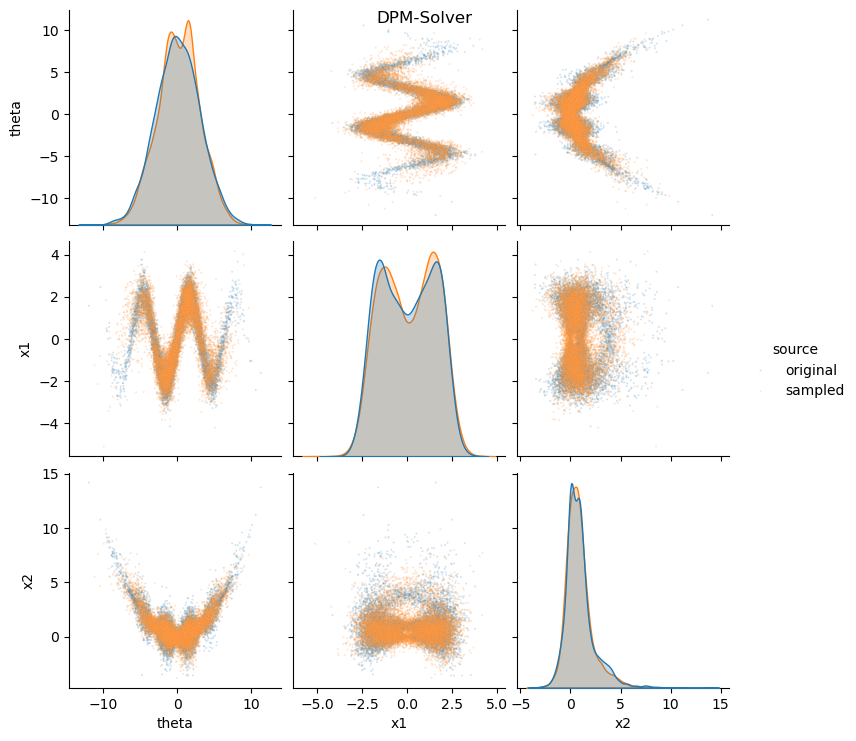

In [14]:
df_og = pd.DataFrame(data.T.numpy(), columns=['theta', 'x1', 'x2'])
df = pd.DataFrame(s.permute(2,1,0).flatten(1).T.cpu().numpy(), columns=['theta', 'x1', 'x2'])

df_og['source'] = 'original'
df['source'] = 'sampled'

df_combined = pd.concat([df_og, df], axis=0)

pp = sns.pairplot(df_combined, hue='source', diag_kind='kde', diag_kws=dict(common_norm=False), plot_kws=dict(alpha=0.2, s=2))
pp.fig.suptitle("DPM-Solver")
plt.show()

In [15]:
posterior=gaussian_kde(s.permute(2,1,0).flatten(1).cpu().numpy())

In [16]:
posterior.pdf([0,0,0])

array([0.02518382])

In [17]:
def map_kde(samples):
    """Find the joint mode of the multivariate distribution"""
    s = samples.numpy()
    kde = gaussian_kde(s)  # KDE expects (n_dims, n_samples)
    
    # Start optimization from the mean
    initial_guess = np.mean(s, axis=1)
    
    # Use full minimize with multiple dimensions
    result = optimize.minimize(lambda x: -kde(x.reshape(-1, 1)), initial_guess)
    std_devs = np.sqrt(np.diag(kde.covariance))

    return result.x, std_devs

In [18]:
map_kde(s.permute(2,1,0).flatten(1).cpu())

(array([-0.58880851, -0.77584393, -0.00080458]),
 array([0.75969534, 0.40221679, 0.35777838]))

In [19]:
posterior.pdf(map_kde(s.permute(2,1,0).flatten(1).cpu())[0])

array([0.02845489])

In [20]:
def map_kde(samples):
    """Find the joint mode of the multivariate distribution"""
    s = samples.numpy()
    kde = gaussian_kde(s.T)  # KDE expects (n_dims, n_samples)
    
    # Start optimization from the mean
    initial_guess = np.mean(s, axis=0)
    
    # Use full minimize with multiple dimensions
    result = optimize.minimize(lambda x: -kde(x.reshape(-1, 1)), initial_guess)
    std_devs = np.sqrt(np.diag(kde.covariance))

    return result.x, std_devs

In [21]:
s.shape

torch.Size([10, 1000, 3])

In [22]:
map0, std0 = map_kde(s.permute(2,1,0).flatten(1).cpu().T)
print(map0)
print(std0)

[-0.58880851 -0.77584393 -0.00080458]
[0.75969534 0.40221679 0.35777838]
